In [37]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt

Reading the dataset from the ab_testing.csv file

In [38]:
df1 = pd.read_csv('ab_testing.csv')

## Goal 1: Determine if the new website version leads to more conversions than the old version

### Objective 1.1: Determine the difference in conversions between the treatment and control groups

#### Deliverable 1.1.1 The probability that a user converts regardless of the page they receive

Printing the top few rows

In [39]:
df1.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


Renaming columns for easier manipulation

In [40]:
new_cols = ['userid','group','page_views','timespent','converted','device','location']
df1.columns = new_cols

In [41]:
df1.head()

,userid,group,page_views,timespent,converted,device,location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


Changing converted to boolean format so it can be analyzed easily

In [42]:
df1.converted = df1.converted.replace({'No':0,'Yes':1})

/var/folders/_l/vgkb2xzx3_l4r29mfzvw6qth0000gn/T/ipykernel_6603/2419052932.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1.converted = df1.converted.replace({'No':0,'Yes':1})


In [43]:
df1.converted.nunique()

2

Finding the number of rows in the dataset

In [44]:
df1.shape

(5000, 7)

Finding the number of unique users in the dataset

In [45]:
df1['userid'].nunique()

5000

Proportion of users converted (The probability that a user converts regardless of the page they receive). This is the overall converted success rate in the population

In [70]:
p_population = df1['converted'].mean()
p_population

np.float64(0.097)

#### Deliverable 1.1.2: The probability that a user converts given that they were in the control group, and the probability given that they are in the treatment group

The probability that an individual converted given that they were in the treatment group

In [47]:
c_rate = df1[df1['group'] == 'A'].converted.mean()
print(c_rate)

0.05398967844382691


The probability that an individual converted given that they are in the tratment group

In [48]:
t_rate = df1[df1['group'] == 'B'].converted.mean()
print(t_rate)

0.14066908504635228


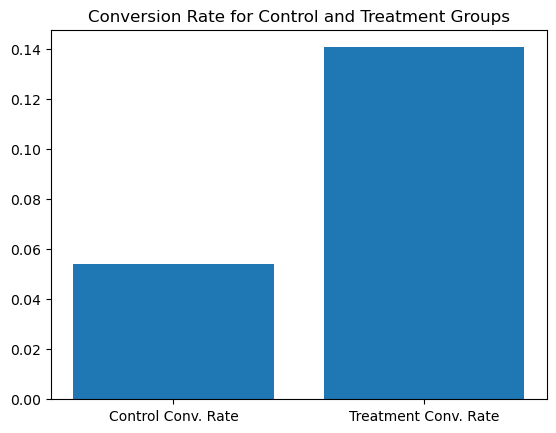

In [74]:
plt.bar(["Control Conv. Rate","Treatment Conv. Rate"],[c_rate,t_rate])
plt.title("Conversion Rate for Control and Treatment Groups")
plt.show()

#### Deliverable 1.1.3: The difference in the probability of conversion between the treatment and control groups

In [49]:
obs_diff = t_rate - c_rate
obs_diff

np.float64(0.08667940660252538)

### Objective 1.2: Determine if the difference in conversions is statistically significant

#### Deliverable 1.2.1: A null and alternative hypothesis for the A/B Test

The null hypothesis  $H_0$
  is that the converted rate for the old page $Pold$ is greater or equal to the converted rate for the new page $Pnew$

  $H_0:Pold>=Pnew$

The alternative hypothesis $H_1$ is that the converted rate for the new page $Pnew$, is greater than the converted rate for the old page $Pnew$

$H_1:Pnew>Pold$

Under the null hypothesis H_0, assume that $Pnew$ and $Pold$ are equal. Furthermore, assume that $Pnew$ and $Pold$ both are equal to the converted success rate in the df2 data, regardless of the page. So, our assumption is:


$Pnew$ = $Pold$ = $P$population

#### Deliverable 1.2.2: The result of the hypothesis test with a p-value

The conversion rate $Pnew$ under the null hypothesis

In [50]:
p_new = round(df1.converted.mean(), 4)
p_new

np.float64(0.097)

In [51]:
p_old = round(df1.converted.mean(), 4)
p_old

np.float64(0.097)

Number of individuals in the treatment group $n_{new}$

In [52]:
n_new = df1[df1['group'] == 'B'].shape[0]
n_new

2481

In [53]:
n_old =df1[df1['group'] == 'A'].shape[0]
n_old

2519

Simulating sample for the treatment group(B)

In [54]:
# Simulating a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_population, p_population])

In [55]:
# Simulating a Sample for the control Group
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_population, p_population])

Finding the difference in the "converted" probability (p'new - p'old) for the simulated samples.

In [56]:
new_page_converted.mean() - old_page_converted.mean()

np.float64(-0.005271184463614617)

Re-creating new_page_converted and old_page_converted and finding the  (p′new-p′old) value 10,000 times using the same simulation process.

In [57]:
# Sampling distribution 
p_diffs = []
new_converted = np.random.binomial(n_new,p_population, 10000)/n_new
old_converted = np.random.binomial(n_old,p_population, 10000)/n_old
p_diffs = new_converted- old_converted

Plotting a histogram with a line where the actual difference observed is.

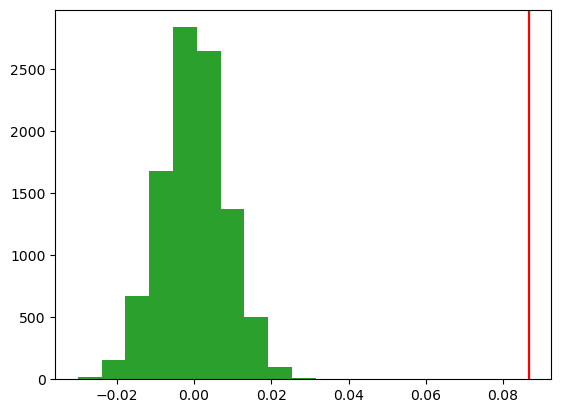

In [69]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red')
plt.show();

The proportion of the p_diffs greater than the actual difference observed.

In [59]:
null_mean = 0
(p_diffs > obs_diff).mean() 

np.float64(0.0)

What we have calculated above is the p value. In this case, we have got a p-value of 0, the p-value represents the probability that an observation comes from the null hypothesis. If we want to get a type I error rate equal to or less than 0.05, then the p-value should be equal to or less than that.

In this case, there is a 0% chance that the observation comes from the null hypothesis; this also means that we have enough evidence to reject the hypothesis. In other words, we have proved that the new page performes better than the old page.

## Goal 2: Use an Alternative method to A/B test to compare results

### Objective 2.1: Conduct a statistical test using regression

#### Deliverable 2.1.1: A logistic regression model that returns new and old page coefficient

We will use logistic regression since the output that we want to get is categorical.
In order to make the analysis we will use a dummy variables that will allow us to compare the dummy variable to the baseline.

In [60]:
import statsmodels.api as sm

Creating an intercept and a dummy variable column.

In [61]:
df1['intercept'] = 1

In [62]:
df1[['ab_page2', 'ab_page']] = pd.get_dummies(df1['group']).astype(int)

In [63]:
df1.head()

,userid,group,page_views,timespent,converted,device,location,intercept,ab_page2,ab_page
0,14292,B,3,424,0,Mobile,Northern Ireland,1,0,1
1,11682,A,9,342,0,Mobile,Scotland,1,1,0
2,19825,A,2,396,0,Desktop,Northern Ireland,1,1,0
3,16080,B,4,318,0,Desktop,Wales,1,0,1
4,18851,A,1,338,1,Desktop,Scotland,1,1,0


 Using statsmodels to instantiate the regression model on the two columns above, then fitting the model to predict whether or not an individual converts.

In [64]:
logit_m = sm.Logit(df1['converted'], df1[['intercept', 'ab_page']])
result = logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.307393
         Iterations 7


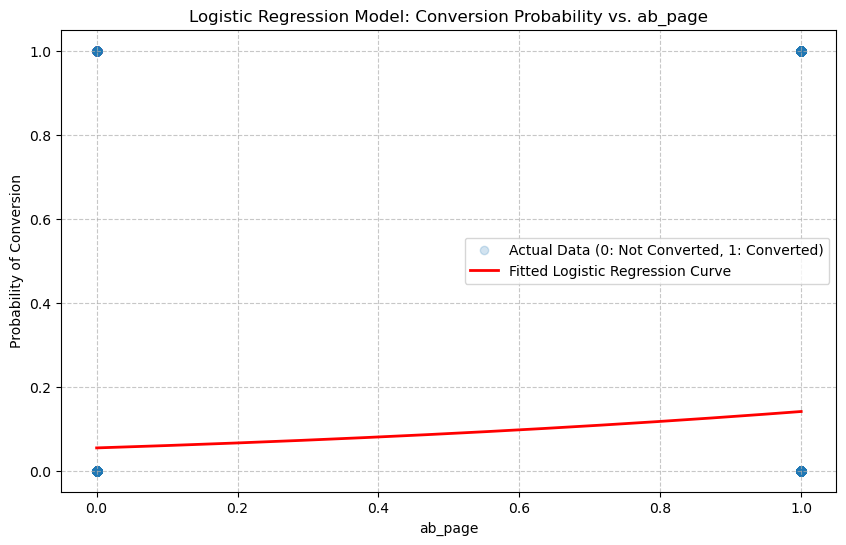

In [75]:
ab_page_range = np.linspace(df1['ab_page'].min(), df1['ab_page'].max(), 500)
X_plot = sm.add_constant(ab_page_range) # Add intercept to the plotting data

# Predict the probabilities using the fitted model
predicted_probabilities = result.predict(X_plot)

# 2. Plot the original data points
plt.figure(figsize=(10, 6))
plt.scatter(df1['ab_page'], df1['converted'], alpha=0.2, label='Actual Data (0: Not Converted, 1: Converted)')

# 3. Plot the fitted logistic regression curve
plt.plot(ab_page_range, predicted_probabilities, color='red', linewidth=2, label='Fitted Logistic Regression Curve')

# Add labels and title
plt.xlabel('ab_page')
plt.ylabel('Probability of Conversion')
plt.title('Logistic Regression Model: Conversion Probability vs. ab_page')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Providing summary of the model below

In [65]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: converted        Pseudo R-squared: 0.035     
Date:               2025-06-01 10:52 AIC:              3077.9257 
No. Observations:   5000             BIC:              3090.9601 
Df Model:           1                Log-Likelihood:   -1537.0   
Df Residuals:       4998             LL-Null:          -1592.2   
Converged:          1.0000           LLR p-value:      7.6810e-26
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept    -2.8635    0.0882  -32.4794  0.0000  -3.0363  -2.6907
ab_page       1.0537    0.1054    9.9983  0.0000   0.8472   1.2603
=================================================================

"""

In [66]:
#computing the exponential and reciprocal to obtain the multiplicative change for ab_page
np.exp(1.0537)

np.float64(2.868244011969)

When using the logistic regression model, we get a coefficient for ab_page with a value of 1.0537, which is a comparison to the baseline, which is -2.8635.

In order to make it easier to understand the results, we exponentiate the coefficient for ab_page, which gives a result of 2.8682. This means that when shown the new page, an individual is 2.86 times more likely to convert than when shown the old page.

The null hypothesis associated with the regression model is that there is no difference in the likelihood of conversion for the new page and the old page. The alternative hypothesis would be that there is a difference in the likelihood of conversion for the old and new pages.

However, from the results we described before, we can conclude that we reject the null hypothesis since we have a p-value of zero.